In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
! pip install optuna
import optuna # for hyperparameter tuning

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 10.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_directory = '/content/drive/vehicles'
file_directory

'/content/drive/vehicles'

In [ ]:
data_directory = '/content/drive/vehicles.zip'
data_directory

'/content/drive/vehicles.zip'

In [ ]:
import os
train_directory = '/content/drive/MyDrive/vehicles/Dataset/train'
test_directory = '/content/drive/MyDrive/vehicles/Dataset/test'
print("Train folder:", train_directory)
print("Test folder:", test_directory)

for folder in [train_directory, test_directory]:
    print("\n", folder)
    for cls in os.listdir(folder):
        print(" ", cls, ":", len(os.listdir(os.path.join(folder, cls))), "images")

Train folder: /content/drive/MyDrive/vehicles/Dataset/train
Test folder: /content/drive/MyDrive/vehicles/Dataset/test

 /content/drive/MyDrive/vehicles/Dataset/train
  Bus : 876 images
  Car : 1143 images
  Heavy_truck : 1585 images
  light_truck : 442 images
  motorcycle : 433 images

 /content/drive/MyDrive/vehicles/Dataset/test
  Bus : 220 images
  Car : 286 images
  Heavy_truck : 397 images
  light_truck : 111 images
  motorcycle : 109 images


#Resize the image to match the input's dimensions.

In [ ]:
import tensorflow as tf

IMG_SIZE = 224

batch_size = 128
img_height = 299
img_width = 299


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_directory,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=True,
  seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_directory,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=False,
  seed=123
)

def format_image(image, label):

    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Normalisation
    image = image/255.0
    return image, label

# Use the previously created train_ds and val_ds, apply format_image for resizing and normalization.
processed_train_ds = train_ds.map(format_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
processed_val_ds = val_ds.map(format_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 4479 files belonging to 5 classes.
Found 1123 files belonging to 5 classes.


In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
# Extract features and labels from processed_train_ds
X_train_list = []
y_train_list = []
for images, labels in processed_train_ds:
    X_train_list.append(images.numpy())
    y_train_list.append(labels.numpy())
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)


Flatten the image data and convert the one-hot encoded labels into single categorical integers for the `XGBoostClassifier`.

In [ ]:
# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert one-hot encoded labels to categorical labels (integers)
y_train_cat = np.argmax(y_train, axis=1)
y_test_cat = np.argmax(y_test, axis=1)

print("Shape of X_train_flat:", X_train_flat.shape)
print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of X_test_flat:", X_test_flat.shape)
print("Shape of y_test_cat:", y_test_cat.shape)

Perform transfer learning to improve the model's performance and accuracy. A comparison of the MobileNetV2 and EfficientNetV2B2 is compared, which are both lightweight and flexible.

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 5

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,              # Stop after 5 epochs with no improvement
    restore_best_weights=True
)


In [ ]:
batch_size = 128
img_height = 299
img_width = 299

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_directory,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=True,
  seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_directory,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=False,
  seed=123
)

Found 4479 files belonging to 5 classes.
Found 1123 files belonging to 5 classes.


In [ ]:
history = model.fit(
    processed_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=processed_val_ds,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.1071 - loss: 2.2658 - val_accuracy: 0.3259 - val_loss: 1.5201
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3426 - loss: 1.5219 - val_accuracy: 0.6563 - val_loss: 1.0729
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5955 - loss: 1.1253 - val_accuracy: 0.8068 - val_loss: 0.7915
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7338 - loss: 0.8592 - val_accuracy: 0.8593 - val_loss: 0.6138
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8079 - loss: 0.7014 - val_accuracy: 0.8896 - val_loss: 0.5000


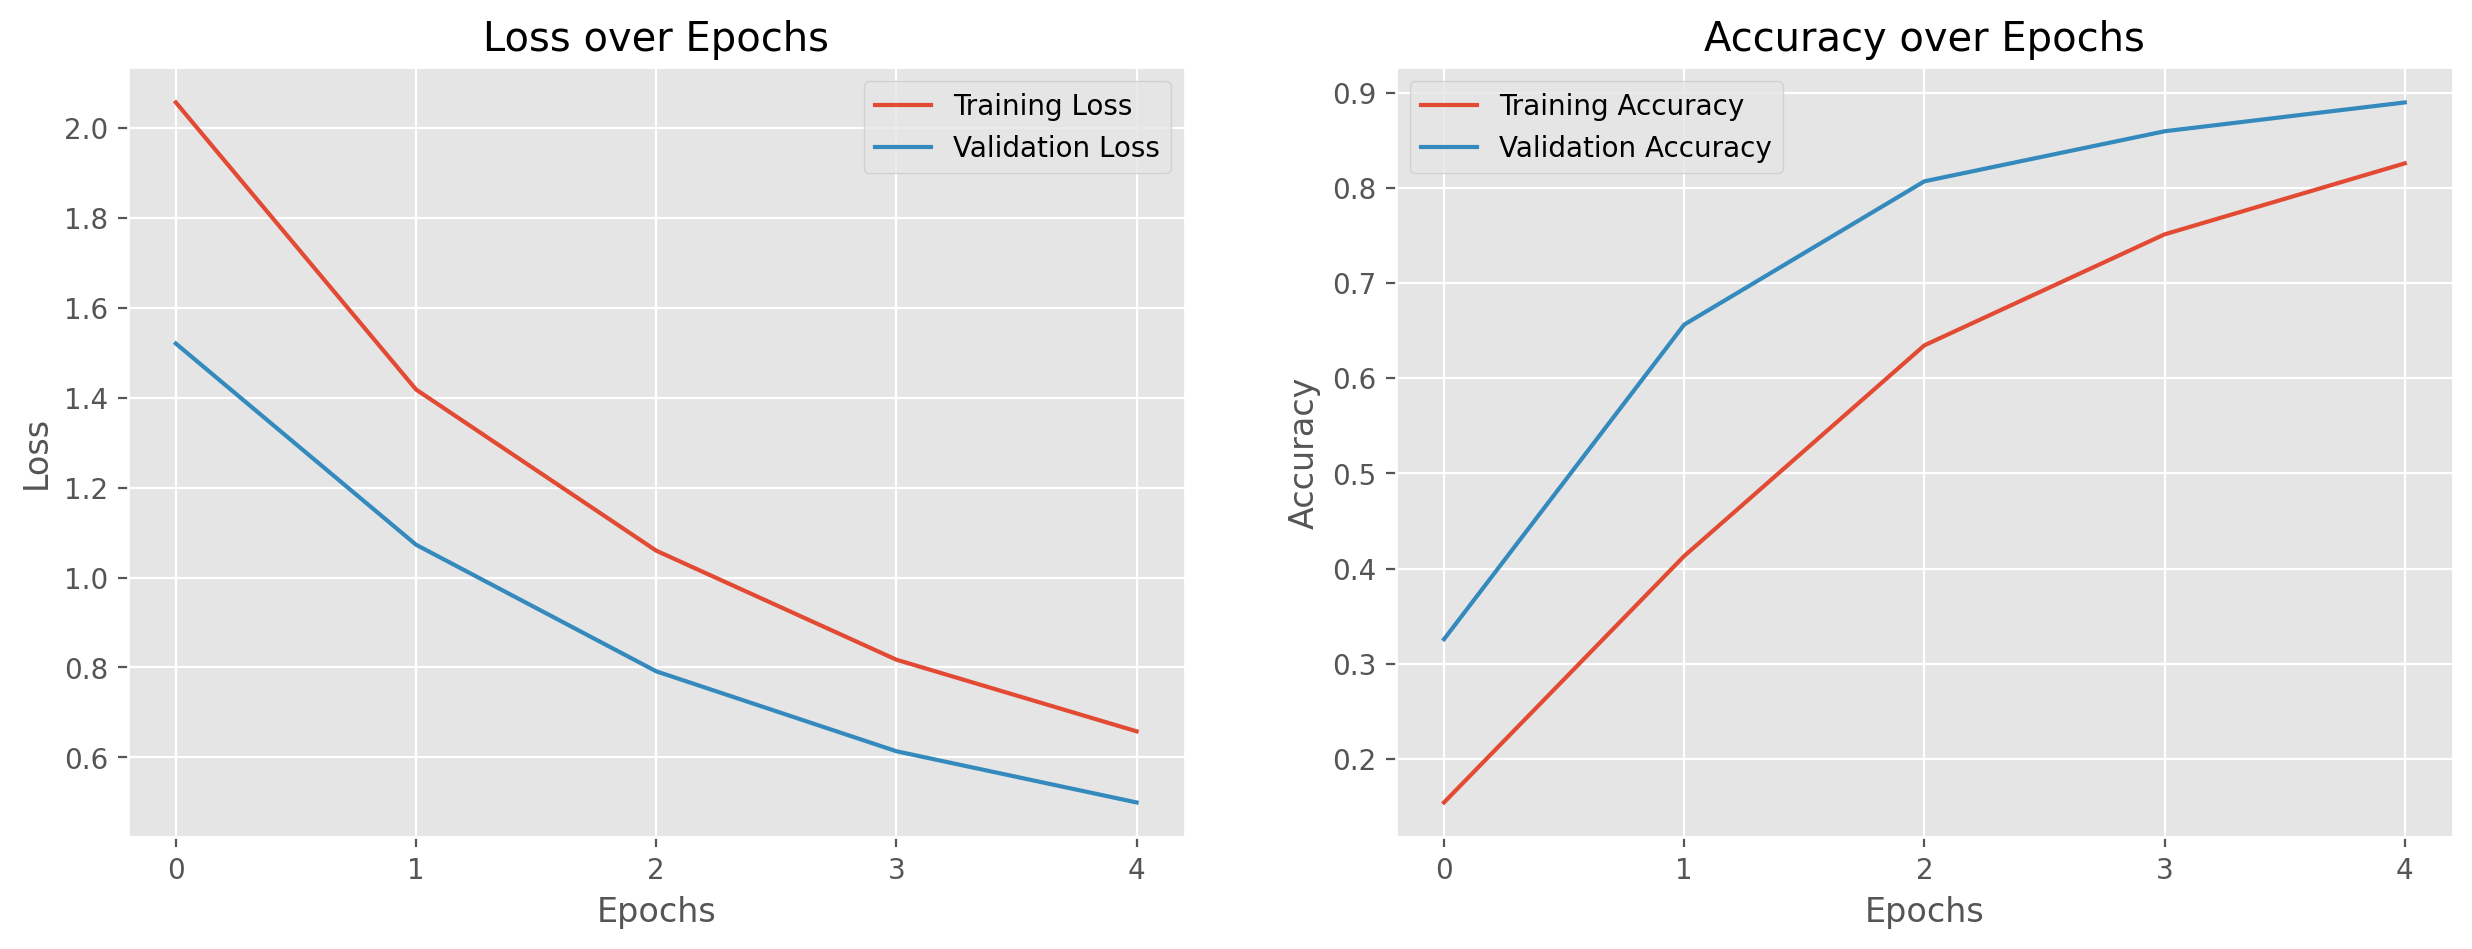

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [ ]:
predictions = model.predict(processed_val_ds)
test_loss, test_accuracy = model.evaluate(processed_val_ds)
print("Test Loss:", test_loss, '%')
print("Test Accuracy:", test_accuracy, '%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 837ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 623ms/step - accuracy: 0.9304 - loss: 0.4205
Test Loss: 0.5000007748603821 %
Test Accuracy: 0.8895815014839172 %


In [ ]:
# Compare EfficientNetV2B2 and MobileNetV2 performance and accuracy
pretrained_model2 = tf.keras.applications.EfficientNetV2B2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

model2 = tf.keras.Sequential([
    pretrained_model,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
pretrained_model2.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 5

In [ ]:
history2 = model2.fit(
    processed_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=processed_val_ds,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4066 - loss: 1.7725 - val_accuracy: 0.8121 - val_loss: 0.5446
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7983 - loss: 0.6012 - val_accuracy: 0.9012 - val_loss: 0.3016
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8826 - loss: 0.3622 - val_accuracy: 0.9225 - val_loss: 0.2275
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9081 - loss: 0.2602 - val_accuracy: 0.9297 - val_loss: 0.1900
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9282 - loss: 0.2195 - val_accuracy: 0.9448 - val_loss: 0.1641


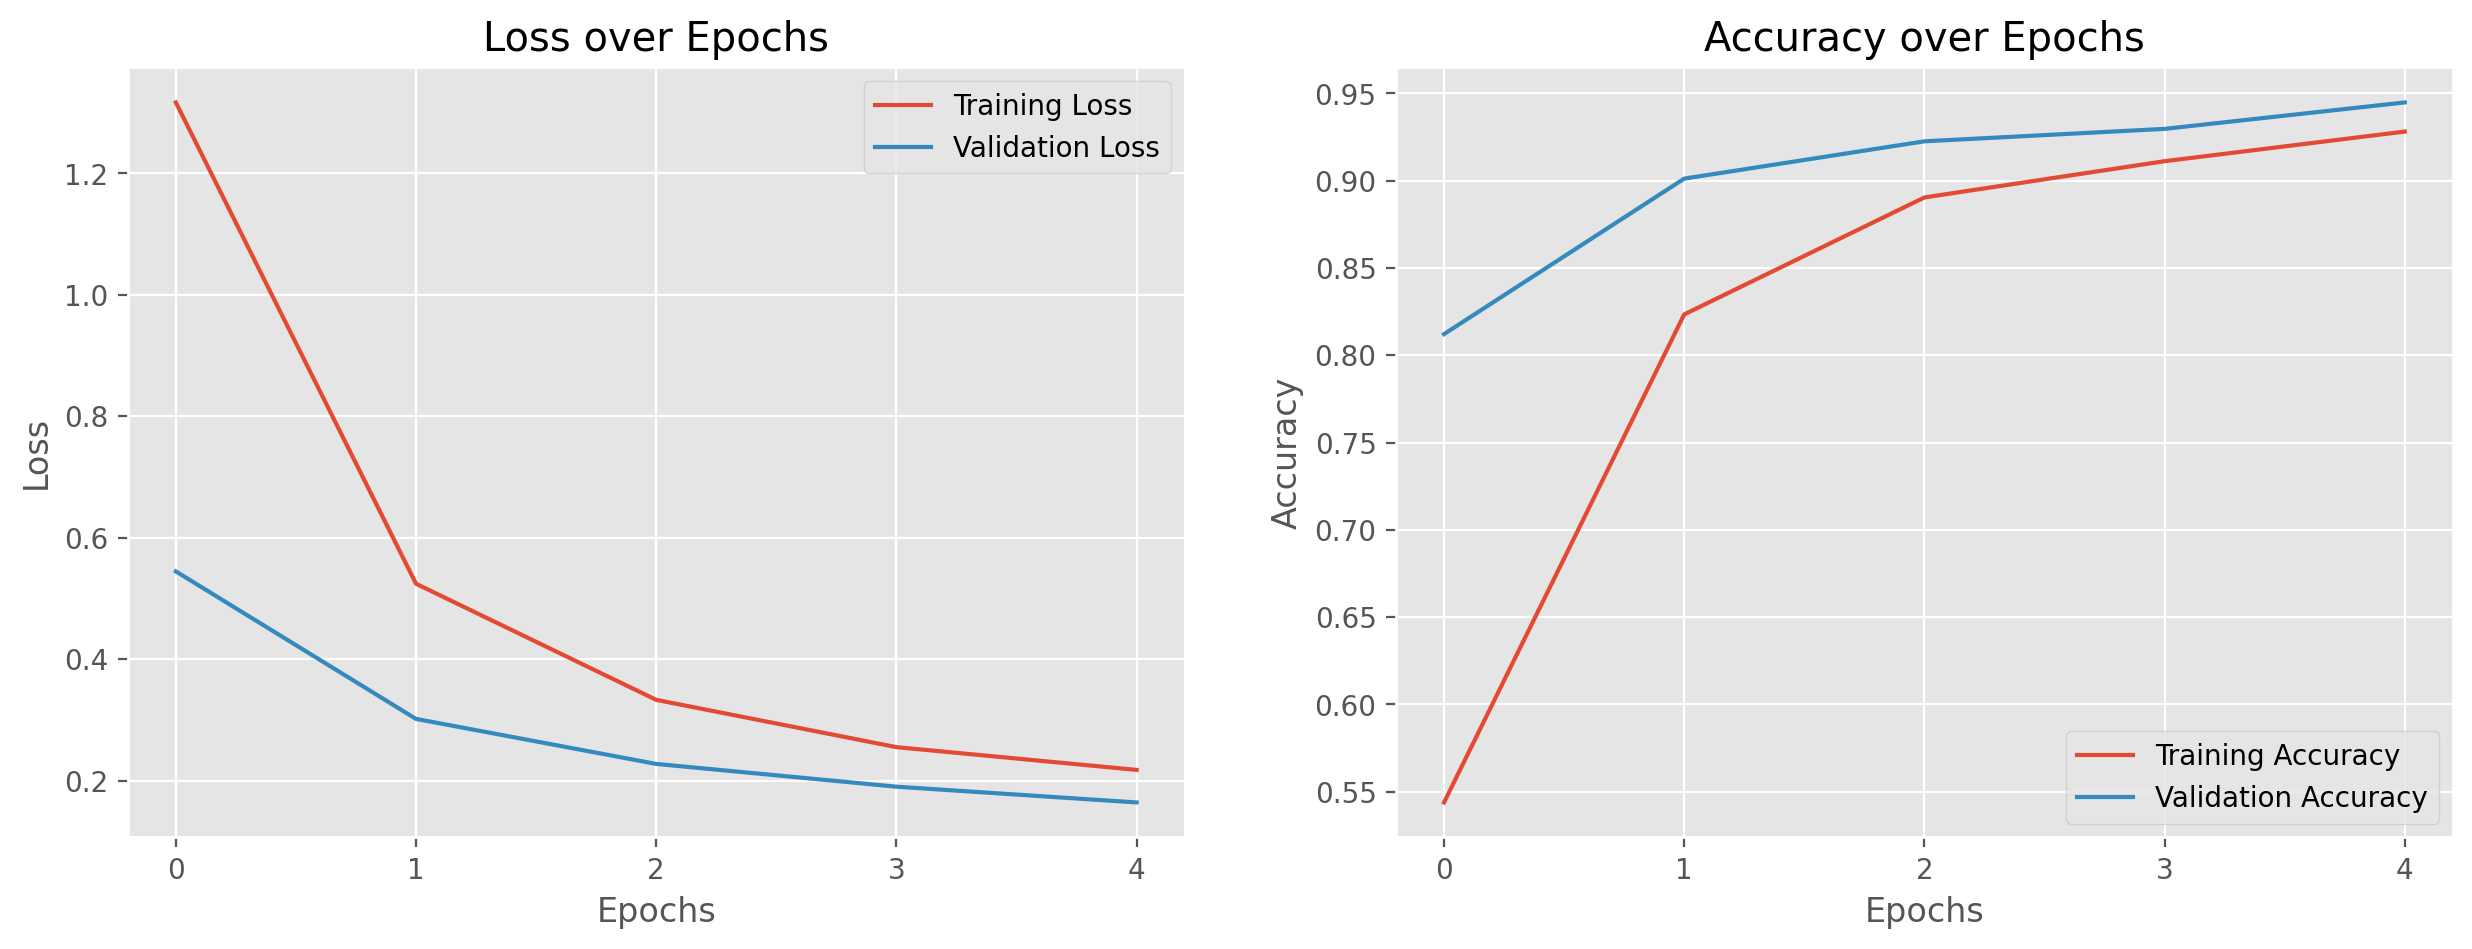

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history2.history['loss'], label='Training Loss')
axes[0].plot(history2.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axes[1].plot(history2.history['accuracy'], label='Training Accuracy')
axes[1].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [ ]:
predictions2 = model2.predict(processed_val_ds)
test_loss2, test_accuracy2 = model2.evaluate(processed_val_ds)
print("Test Loss:", test_loss2, '%')
print("Test Accuracy:", test_accuracy2, '%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 859ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - accuracy: 0.9611 - loss: 0.1214
Test Loss: 0.16408628225326538 %
Test Accuracy: 0.9447907209396362 %


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a simple Neural Network
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        # MNIST images are 28x28
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.relu = nn.ReLU()
        # MNIST has 10 classes
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Hyperparameter tuning with Optuna

def objective(trial):
  hidden_size = trial.suggest_int('hidden_size', 128, 512)
  learning_rate = trial.suggest_float('lr', 1e-4, 1e-1, log=True)

  transform = transforms.Compose([transforms.ToTensor()])
  train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=32, shuffle=True)

  model = Net(hidden_size)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  model.train()
  for epoch in range(1):
    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
  output = model(data)
  loss = criterion(output, target)
  loss.backward()
  optimizer.step()

  return loss.item()

In [ ]:
study = optuna.create_study(direction='minimize') # seeks for the low gradient values
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

[I 2026-02-03 04:05:04,818] A new study created in memory with name: no-name-ec875b44-ca41-4f42-857d-65b8c941b1c7
[I 2026-02-03 04:05:13,162] Trial 0 finished with value: 2.3037021160125732 and parameters: {'hidden_size': 444, 'lr': 0.0012167868163578995}. Best is trial 0 with value: 2.3037021160125732.
[I 2026-02-03 04:05:20,490] Trial 1 finished with value: 2.3097589015960693 and parameters: {'hidden_size': 408, 'lr': 0.0014756513798071347}. Best is trial 0 with value: 2.3037021160125732.
[I 2026-02-03 04:05:28,860] Trial 2 finished with value: 2.3121511936187744 and parameters: {'hidden_size': 188, 'lr': 0.06052112642293491}. Best is trial 0 with value: 2.3037021160125732.
[I 2026-02-03 04:05:36,405] Trial 3 finished with value: 2.328369140625 and parameters: {'hidden_size': 186, 'lr': 0.00029621164933957294}. Best is trial 0 with value: 2.3037021160125732.
[I 2026-02-03 04:05:44,445] Trial 4 finished with value: 2.326514959335327 and parameters: {'hidden_size': 384, 'lr': 0.0001725

Best Hyperparameters: {'hidden_size': 148, 'lr': 0.012446682697901999}


In [ ]:
! pip install xgboost

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)

print("TensorFlow Lite model saved as model.tflite.")

Saved artifact at '/tmp/tmp4tgd5cx3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_667')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138119304152656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304154000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304153808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304153232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304154576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304152848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304154192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304154384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304153424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138119304155536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1381193041